# Description

**Author:** Anna Luisa Hemshorn de Sánchez

**Affiliation:** (1) Department of Earth Sciences, VU Amsterdam, (2) Institute of Environmental Studies (IVM), VU Amsterdam, (3) Deltares

**Contact:** a.l.hemshorndesanchez@vu.nl

**Version:** V1

**Date:** Oct 20, 2025

**Description:** Data used in this notebook is obtained from: do Nascimento, T.V.M., Rudlang, J., Höge, M. et al. EStreams: An integrated dataset and catalogue of streamflow, hydro-climatic and landscape variables for Europe. _Sci Data_ 11, 879 (2024). https://doi.org/10.1038/s41597-024-03706-1

In this version of the code we filter the catchments contained in the EStreams dataset according to different selection criteria.


# Import packages

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from cmcrameri import cm 
from pathlib import Path

# Define file paths

In [2]:
# Get main directories
nb_dir = Path.cwd()
parent_dir = nb_dir.parent.parent.parent.parent
fp = parent_dir / "Data/Europe/estreams/EStreams_v1.3/"
fp_gh = parent_dir / "Code/GitHub/streamflow_sensitivity_europe/"

# Input directories and filepaths
fp_gauges = fp / "streamflow_gauges/estreams_gauging_stations.csv"
fp_met = fp / "meteorology/" # contains: estreams_meteorology_{basin_id}.csv
fp_hydsig = fp / "hydroclimatic_signatures/estreams_hydrometeo_signatures.csv"
fp_shp_gau = fp / "shapefiles/estreams_gauging_stations.shp"
fp_shp_cat = fp / "shapefiles/estreams_catchments.shp"
fp_attr_stat = fp / "attributes/static_attributes/" # contains: estreams_{attribute_type}_attributes.csv
fp_attr_temp = fp / "attributes/temporal_attributes/" # contains: estreams_{attribute_type}_[time_scale].csv
fp_qidx_mon = fp / "streamflow_indices/monthly/" # contains: monthly_streamflow_{index}.csv

# Output directories
fp_data_processed = fp_gh / "data/processed/" 
fp_figures = fp_gh / "figures/" 

# Filter the data

In [3]:
gauges = pd.read_csv(fp_gauges)
gauges_no = len(gauges.index)
print('Amount of gauges: ', gauges_no,'\n')

def minmaxmean(param, df):
    """""
    Calculate maximum, minimum and mean value of a given parameter in a DataFrame
    
    Parameters:
    - param (str): Column name of the parameter
    - df (pandas.DataFrame): Dataframe containing the column with the parameter of interes
    
    Returns: prints the maximum, minimum and mean values of the parameter
    """""
    varmax = df[param].max()
    varmin = df[param].min()
    varmean = df[param].mean()
    print('The range of ', param,' is :',round(varmax,2), '(max) and ', round(varmin,2), '(min) and the mean is: ', round(varmean,2))
    return
    
def gauge_filter(gauges_in, param, varmin=None, varmax=None, vareq=None): 

    """""
    Filter gauges according to the variable limits given for a chosen parameter.
    
    Parameters:
    - gauges_in (pandas.DataFrame): DataFrame of the gauges with columns of different parameters that are used for filtering
    - param (str): Column name of the parameter used for filtering
    - varmin (float): Optional limit value to only consider gauges with parameter values larger than varmin
    - varmax (float): Optional limit value to only consider gauges with parameter values smaller than varmax
    - vareq (float): Optional value to only consider gauges with parameter values equal to vareq
    
    Returns: 
    - gauges_out (pandas.DataFrame)
    - gauge_id (list)
    - basin_id (list)
    """""
    
    gauges_out = gauges_in
    
    if vareq != None:
        gauges_out = gauges_in[gauges_in[param].isin(vareq)]
        print('Amount of catchments with ', param, '==', vareq, ':',len(gauges_out))
        
    if varmin != None:
        gauges_out = gauges_in[gauges_in[param] > varmin]
        print('Amount of catchments with ', param, '>', varmin, ':',len(gauges_out))
        
    if varmax != None:
        gauges_out = gauges_in[gauges_in[param] < varmax]
        print('Amount of catchments with ', param, '<', varmax, ':',len(gauges_out))

        
    # Get indices of filtered rows and use them to apply filter
    gauge_id = gauges_out['gauge_id'] 
    basin_id = gauges_out['basin_id'] 
    
    return gauges_out, gauge_id, basin_id

def basin_filter(basins_in, param, varmin=None, varmax=None, vareq=None): 
    """""
    Filter basins according to the variable limits given for a chosen parameter.
    
    Parameters:
    - basins_in (DataFrame): Dataframe of the basins with columns of different parameters that are used for filtering
    - param (str): Column name of the parameter used for filtering
    - varmin (float): Optional limit value to only consider gauges with parameter values larger than varmin
    - varmax (float): Optional limit value to only consider gauges with parameter values smaller than varmax
    - vareq (float): Optional value to only consider gauges with parameter values equal to vareq
    
    Returns: 
    - basins_out (DataFrame)
    - basin_id (list)
    """""

    basins_out = basins_in
    
    if vareq != None:
        basins_out = basins_in[basins_in[param].isin(vareq)]
        print('Amount of catchments with ', param, '==', vareq, ':',len(basins_out))
        
    if varmin != None:
        basins_out = basins_in[basins_in[param] > varmin]
        print('Amount of catchments with ', param, '>', varmin, ':',len(basins_out))
        
    if varmax != None:
        basins_out = basins_in[basins_in[param] < varmax]
        print('Amount of catchments with ', param, '<', varmax, ':',len(basins_out))
    
        
    # Get indices of filtered rows and use them to apply filter to cmls_catch_no
    #gauge_id = basins_out['gauge_id'] #or name of catchment ID
    basin_id = basins_out['basin_id'] 
    
    return basins_out, basin_id #gauge_id

Amount of gauges:  17130 



## Filter by gauge characteristics

The 'area_flag' contains the following flags:

* 0: |Arel| below 10%.
* 1: |Arel| below 10% after moving the gauge location.
* 2: |Arel| above 10% or no reported area available, but delineation visually compared to other delineations from down and upstream gauges labeled "0", Google Maps satellite imagery and to the EU-Copernicus River network.
* 3: |Arel| above 10% or no reported area available, but delineation visually compared to Google Maps satellite imagery and to the EU-Copernicus River network.
* 4: |Arel| above 30% or no reported area available, but delineation compared to EU- Copernicus River network.
* 5: |Arel| above 10% or no reported area available, and delineation manually adjusted using EU-Copernicus in addition to MERIT-Hydro.
* 6: Similar to “5”, but still with |Arel| above 30% or no reported area available.
* 888: |Arel| above 10% or no reported area available, but location in areas under high human influence, such as canalization and water exports and in karstic regions.
* 999: |Arel| above 10% or no reported area available, and delineation eventually not accepted after visual inspection.

In [4]:
# Filter by basin area quality flag
gau, gau_gid, gau_bid = gauge_filter(gauges_in=gauges, param='area_flag', varmin=None, varmax=None, vareq=[0,1,2,3,4,5,6]) #,2,3

Amount of catchments with  area_flag == [0, 1, 2, 3, 4, 5, 6] : 14793


The 'gauge_flag' contains the following flags:

* A: More than 95% of the gauge records flags are “reliable”
* B: More than 95% of the gauge records flags are “reliable” or “no-flag”
* C: Less than 10% of the gauge records flags are “missing”
* D: Less than 20% of the gauge records flags are “missing”
* E: More than 20% of the gauge records flags are “missing”

In [5]:
# Filter by gauge quality flag: not using this filter anymore as we use the rule of 10 years (=120 months) of non-nan values of the monthyl timeseries.
#gau, gau_gid, gau_bid = gauge_filter(gauges_in=gau, param='gauge_flag', varmin=None, varmax=None, vareq=['A','B','C'])

In [6]:
# Filter by record length: not using this filter anymore as we use the rule of 10 years (=120 months) of non-nan values of the monthyl timeseries.
#minmaxmean('num_years', gau)
#gau, gau_gid, gau_bid = gauge_filter(gauges_in=gau, param='num_years',varmin=10, varmax=None, vareq=None)

# Filter by area
#minmaxmean('area_estreams', gau)
#gau, gau_gid, gau_bid = gauge_filter(gauges_in=gau, param='area_estreams', varmin=None, varmax=50000, vareq=None) #based on histogram

# Filter by number of suspicious days
minmaxmean('num_days_suspect', gau)
gau, gau_gid, gau_bid = gauge_filter(gauges_in=gau, param='num_days_suspect', varmin=None, varmax=61, vareq=None) 

# Filter by number of gap days
minmaxmean('num_days_gaps', gau)
gau, gau_gid, gau_bid = gauge_filter(gauges_in=gau, param='num_days_gaps', varmin=None, varmax=None, vareq=None) #based on histogram

The range of  num_days_suspect  is : 33052.0 (max) and  0.0 (min) and the mean is:  246.49
Amount of catchments with  num_days_suspect < 61 : 11478
The range of  num_days_gaps  is : 32565.0 (max) and  0.0 (min) and the mean is:  1072.23


## Filter based on meteorology ('estreams_meteorology_density.csv)

In [7]:
met = pd.read_csv(fp_attr_stat/"estreams_meteorology_density.csv")
minmaxmean('stations_dens_p_mean', met)
minmaxmean('stations_dens_p_mean', met[met['basin_id'].isin(gau_bid)])

The range of  stations_dens_p_mean  is : 333.33 (max) and  0.0 (min) and the mean is:  0.09
The range of  stations_dens_p_mean  is : 5.0 (max) and  0.0 (min) and the mean is:  0.06


In [8]:
# Filter by E-OBS station density
met, met_bid = basin_filter(basins_in = met[met['basin_id'].isin(gau_bid)],param='stations_dens_p_mean',
                                    varmin=None, # 0.01 corresponds to 1 per 100km2 # To include Dutch catchments it needs: 0.005 #= 1 per 200km2 
                                    varmax=None,
                                    vareq=None)

## Filter based on hydrological signatures (estreams_hydrometeo_signatures.csv)

In [9]:
hydsig = pd.read_csv(fp_hydsig)
hydsig_no = len(hydsig.index)
minmaxmean('frac_snow', hydsig)

The range of  frac_snow  is : 0.59 (max) and  0.0 (min) and the mean is:  0.08


In [10]:
# Filter by snow fraction
hys, hys_bid = basin_filter(basins_in = hydsig[hydsig['basin_id'].isin(met_bid)],
                                    param='frac_snow', 
                                    varmin=None, 
                                    varmax=None, #0.15, 
                                    vareq=None)

# Filter by runoff ratio
minmaxmean('q_runoff_ratio', hydsig)
minmaxmean('q_runoff_ratio', hys)
hys, hys_bid = basin_filter(basins_in = hys[hys['basin_id'].isin(hys_bid)],
                                    param='q_runoff_ratio', 
                                    varmin=None, 
                                    varmax=1.5, #1.3
                                    vareq=None)

# Filter by seasonality
minmaxmean('p_seasonality', hydsig)
minmaxmean('p_seasonality', hys)
hys, hys_bid = basin_filter(basins_in = hys[hys['basin_id'].isin(hys_bid)],
                                    param='p_seasonality', 
                                    varmin=None, 
                                    varmax=None,
                                    vareq=None)

The range of  q_runoff_ratio  is : 6.215506841235374e+30 (max) and  0.0 (min) and the mean is:  4.598628914793855e+26
The range of  q_runoff_ratio  is : 6.215506841235374e+30 (max) and  0.0 (min) and the mean is:  6.042098611096893e+26
Amount of catchments with  q_runoff_ratio < 1.5 : 10022
The range of  p_seasonality  is : 0.66 (max) and  -0.99 (min) and the mean is:  0.04
The range of  p_seasonality  is : 0.66 (max) and  -0.99 (min) and the mean is:  0.09


## Filter by soil attributes (estreams_soil_attributes.csv)

In [11]:
soil = pd.read_csv(fp_attr_stat/"estreams_soil_attributes.csv")
minmaxmean('soil_fra_sand_mean', soil) # soil_fra_sand_mean, soil_fra_sand_max, soil_fra_sand_min

The range of  soil_fra_sand_mean  is : 90.0 (max) and  0.0 (min) and the mean is:  48.51


In [12]:
soil, soil_bid = basin_filter(basins_in = soil[soil['basin_id'].isin(hys_bid)],
                                    param='soil_fra_sand_mean', 
                                    varmin=None, 
                                    varmax=None, 
                                    vareq=None)

## Filter based on topography (estreams_topography_attributes.csv)

In [13]:
topo = pd.read_csv(fp_attr_stat/"estreams_topography_attributes.csv")
minmaxmean('flat_area_fra', topo)

The range of  flat_area_fra  is : 100.0 (max) and  0.0 (min) and the mean is:  46.19


In [14]:
# Filter by slope
minmaxmean('slp_dg_mean', topo) # soil_fra_sand_mean, soil_fra_sand_max, soil_fra_sand_min
topo, topo_bid = basin_filter(basins_in = topo[topo['basin_id'].isin(soil_bid)],
                                    param='slp_dg_mean', 
                                    varmin=None, 
                                    varmax=None, 
                                    vareq=None)

# Filter by flat area fraction
minmaxmean('flat_area_fra', topo)
topo, topo_bid = basin_filter(basins_in = topo[topo['basin_id'].isin(topo_bid)],
                                    param='flat_area_fra', 
                                    varmin=None, 
                                    varmax=None, 
                                    vareq=None)

The range of  slp_dg_mean  is : 35.58 (max) and  0.17 (min) and the mean is:  7.27
The range of  flat_area_fra  is : 100.0 (max) and  0.0 (min) and the mean is:  44.84


## Filter based on quality flags based on visual inspection of the hydrograph

In [15]:
# Filter by our hydrograph flags
hflag = pd.read_csv(fp_data_processed/"01_selection/station_list_suspect_VU.csv")[['Station_ID','M_grouped']]
#print('Unique hydrograph quality flags: ', hflag['M_grouped'].unique())

hflag_out = ['seasonal_gaps',
             #'dam_shift',
             'long_0_values',
             #'unknown_shift', 
             #'single_outlier',
             'spiky_pattern',
             'repeating_value',
             'binary_pattern', 
             'strange_pattern',
             'other',
             'flat_periods',
             'long_linear_interpolation',
             'blocky_pattern',
             'noisy_pattern',
             'patchy_pattern',
             'frequent_gaps',
             'magnitude_shift',
             'scattered_periods'
            ]
hflag = hflag[hflag['M_grouped'].isin(hflag_out)]
print('Amount of catchments that are flagged due to the hydrograph: ', len(hflag))

# Create a selection of strings not appearing in the 'M_g' column of filtered_df
hflag_bid = topo_bid[~topo_bid.isin(hflag['Station_ID'])]
print('The amount of catchments after filtering for hydrograph flag: ', len(hflag_bid))

Amount of catchments that are flagged due to the hydrograph:  266
The amount of catchments after filtering for hydrograph flag:  9906


# Filter by total length of non NaN data

In [16]:
Q_mon = pd.read_csv(fp_qidx_mon/"monthly_streamflow_mean.csv", index_col=0, parse_dates=[0])

# Filter rows starting from 1950-01-01
Q_mon = Q_mon[Q_mon.index >= "1950-01-01"]

# Select columns that are part of `hflag_bid`
Q_mon = Q_mon[Q_mon.columns[Q_mon.columns.isin(hflag_bid)]]

# Identify locations with at least 10 years (120 months) of non-NaN values
req_months = 10 * 12  # 10 years of monthly data
basin_id_len = Q_mon.notna().sum(axis=0) >= req_months

# Get the list of basin_id locations meeting the criteria
basin_id_len_series = pd.Series(basin_id_len[basin_id_len].index, name='basin_id') # basin_id_len[basin_id_len].index.tolist()

# Output the result
print(f"Locations with at least 10 years of non-NaN values: {len(basin_id_len_series)}")

Locations with at least 10 years of non-NaN values: 8307


In [17]:
basin_id_sel = basin_id_len_series
basin_id_sel.to_csv(fp_data_processed/"01_selection/basin_id_sel.csv")

# Selected catchments as shapefiles

In [18]:
%%time
# Read the shapefile 
shp_gau = gpd.read_file(fp_shp_gau)  
shp_gau.set_crs('EPSG:4326', inplace=True)
shp_cat = gpd.read_file(fp_shp_cat) 

# Filter rows based on 'selection' list and the 'column_for_selection' column
shp_gau_sel = shp_gau[shp_gau['basin_id'].isin(basin_id_sel)].sort_values(by='area_estre', ascending=False)
shp_cat_sel = shp_cat[shp_cat['basin_id'].isin(basin_id_sel)].sort_values(by='area_estre', ascending=False)

# Set basin_id as the index
shp_gau_sel = shp_gau_sel.set_index('basin_id')
shp_cat_sel = shp_cat_sel.set_index('basin_id')

# Load the Europe boundaries (Natural Earth dataset)
europe = gpd.read_file(parent_dir/"Data/Admin/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp")
europe = europe[(europe['CONTINENT'].str.contains('Europe', case=False, na=False)) |
                ((europe.geometry.bounds['minx'] >= -10) &     
                 (europe.geometry.bounds['maxx'] <= 50) &
                 (europe.geometry.bounds['miny'] >= 30) & 
                 (europe.geometry.bounds['maxy'] <= 70))] #europe = europe.cx[-10:50, 30:70] #europe = europe[europe['CONTINENT'] == 'Europe']

CPU times: user 26 s, sys: 288 ms, total: 26.3 s
Wall time: 26.5 s


In [19]:
shp_gau_sel.drop(columns=['gauge_prov', 'area_offic', 'area_flag', 'area_rel',
                          'num_years', 'num_months', 'num_days', 'num_contin','num_days_g', 'num_days_r', 'num_days_n', 'num_days_s', 'gauge_flag','duplicated', 'watershed_'], inplace=True)
shp_cat_sel.drop(columns=['area_offic','area_flag', 'area_rel','gauge_flag', 'upstream', 'group'], inplace=True)
shp_cat_sel

,gauge_id,country,area_estre,start_date,end_date,geometry
basin_id,,,,,,
RUGR0073,6977100,RU,1366923.256,1962-01-01,2010-12-31,"POLYGON Z ((45.10041 49.05541 0.00000, 45.1045..."
ROGR0012,6742900,RO,786297.587,1931-01-01,2010-12-31,"POLYGON Z ((23.58541 42.17958 0.00000, 23.5854..."
ROGR0011,6742800,RO,689465.307,1931-01-01,2010-12-31,"POLYGON Z ((27.42791 44.34958 0.00000, 27.4245..."
ROGR0006,6742500,RO,643182.415,1931-01-01,2010-12-31,"POLYGON Z ((25.30625 43.49541 0.00000, 25.3079..."
ROGR0001,6742200,RO,568599.188,1920-01-01,1990-12-31,"POLYGON Z ((22.19375 44.29291 0.00000, 22.1937..."
...,...,...,...,...,...,...
GB000595,76011,GB,1.631,1967-01-01,2021-09-30,"POLYGON Z ((-2.48179 55.09300 0.00000, -2.4829..."
CH000080,2252,CH,1.377,1981-01-01,2019-07-01,"POLYGON Z ((7.27075 46.70062 0.00000, 7.27088 ..."
CH000069,2206,CH,1.067,1981-01-01,2020-12-31,"POLYGON Z ((9.08964 46.18375 0.00000, 9.09043 ..."


## Check catchment size

Mean catchment area: 4066.76
Maximum catchment area: 1366923.26
Minimum catchment area: 0.56


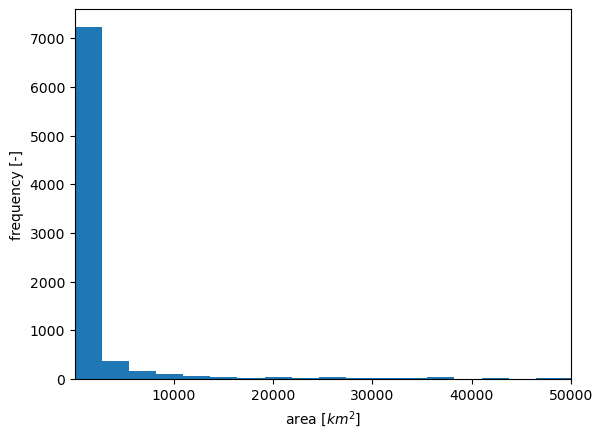

In [20]:
print(f"Mean catchment area: {shp_cat_sel['area_estre'].mean():.2f}")
print(f"Maximum catchment area: {shp_cat_sel['area_estre'].max():.2f}")
print(f"Minimum catchment area: {shp_cat_sel['area_estre'].min():.2f}")

plt.hist(shp_cat_sel['area_estre'], bins=500)
plt.xlim(0.5,50000)
plt.xlabel('area [$km^2$]')
plt.ylabel('frequency [-]')
plt.show()

## Export filtered data to a dataframe which will serve to store all the remaining results into as well

In [21]:
shp_gau_sel['wkt_geometry'] = shp_gau_sel['geometry'].apply(lambda geom: geom.wkt)
shp_gau_sel.to_csv(fp_data_processed/"01_selection/gauges_metadata.csv", index=True)

shp_cat_sel['wkt_geometry'] = shp_cat_sel['geometry'].apply(lambda geom: geom.wkt)
shp_cat_sel.to_csv(fp_data_processed/"01_selection/catchment_metadata.csv", index=True)